Import the libraries necessary to analize data

In [47]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [48]:
df = pd.read_csv('df_scaled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 36 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   povertyPercentage                   197914 non-null  float64
 1   males_percentage_per_district       197914 non-null  float64
 2   child_teen_percentage_per_district  197914 non-null  float64
 3   killed_percentage_per_district      197914 non-null  float64
 4   injured_percentage_per_district     197914 non-null  float64
 5   arrested_percentage_per_district    197914 non-null  float64
 6   unharmed_percentage_per_district    197914 non-null  float64
 7   killed_rate                         197914 non-null  float64
 8   injured_rate                        197914 non-null  float64
 9   arrested_rate                       197914 non-null  float64
 10  survival_rate                       197914 non-null  float64
 11  winning_party_percentage  

We selected one state as stated in subtask of clustering task.

In particular, we decided to select the state with the higher number of gun incidents which resulted Illinois

In [49]:
df['state'].value_counts()

state
illinois          15935
california        13842
florida           12661
texas             11023
new york           8707
ohio               8601
georgia            7634
pennsylvania       7529
north carolina     7254
louisiana          6670
tennessee          6282
missouri           6054
south carolina     5886
massachusetts      5274
michigan           5004
virginia           4845
indiana            4828
new jersey         4693
maryland           4477
alabama            4388
wisconsin          4266
kentucky           3456
oklahoma           3069
mississippi        2990
washington         2900
colorado           2831
connecticut        2731
arkansas           2500
iowa               2333
oregon             2000
arizona            1984
kansas             1949
minnesota          1715
nevada             1589
new mexico         1479
nebraska           1318
west virginia      1285
alaska             1276
utah                916
new hampshire       858
maine               844
rhode isla

In [50]:
df = df.loc[df['state'] == 'illinois']

In [51]:
column_to_drop = ['n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'involve_killing', 'avg_age_participants', 'pc1', 'pc2']
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_participants_adult',
 'n_males',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'involve_killing',
 'avg_age_participants',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [52]:
df_categorical = df[column_to_drop]
df_numeric = df.drop(columns=column_to_drop)

To choose the best eps value we create the distance matrix 

In [53]:
dist = pdist(df_numeric, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist

To choose the epsilon parameter, we will use the elbow method.

In [54]:
k = 10
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

Text(0.5, 0, 'sorted distances')

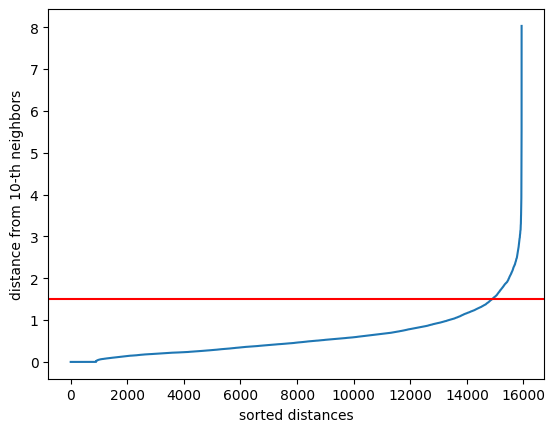

In [55]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.axhline(y=1.5, color='r', linestyle='-')
plt.ylabel(f'distance from {k}-th neighbors')
plt.xlabel('sorted distances')

We can identify the Elbow in the value of 1.5, so this value is a candidate for the Epsilon.

In [57]:
#Coarse grain search for the number of min_samples
#min_samples = [20, 40, 50, 75]
#Finer grain search for the number of min_samples
min_samples = [60, 65, 70, 75]

#Coarse grain search for the number of eps
eps_l = [1.5, 1.6, 1.70, 1.8]
#Finer grain search for the number of eps
#eps_l = [1.7, 1.75, 1.8]

In [58]:
from sklearn import metrics

table = []
for eps in eps_l:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(df_numeric)
        n_clusters = len(np.unique(dbscan.labels_))
        silhouette = metrics.silhouette_score(df_numeric, dbscan.labels_)
        DBscore = metrics.davies_bouldin_score(df_numeric, dbscan.labels_)
        table.append({"eps":eps, "silhouette": silhouette, "DBscore":DBscore, "n_clusters": n_clusters, "min_samples": min_sample})
        

In [59]:
pd.DataFrame(table).sort_values(by="silhouette", ascending=False)


,eps,silhouette,DBscore,n_clusters,min_samples
3,1.5,0.179314,2.663421,3,75
11,1.7,0.160908,2.316443,4,75
12,1.8,0.159740,2.628470,3,60
13,1.8,0.158139,2.611526,3,65
5,1.6,0.157834,2.325878,4,65
6,1.6,0.157197,2.328541,4,70
14,1.8,0.156777,2.616375,3,70
0,1.5,0.154896,2.348897,4,60
7,1.6,0.154162,2.337039,4,75
1,1.5,0.153001,2.334253,4,65


The best looking value of silhouette is the eps 1.5 with 75 samples.

Plotting the result of the clustering on the pca dimensions (pc1 and pc2), labelling each point by the cluster label

noise points: 1712


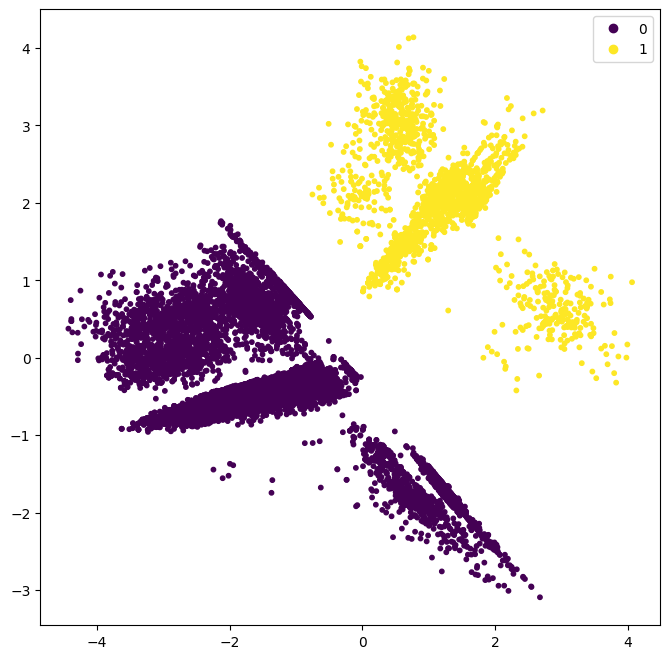

In [60]:
eps = 1.5
min_samples = 75
# Perform DB scan
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(df_numeric)
print(f"noise points: {(dbscan.labels_==-1).sum()}")

plt.figure(figsize=(8,8))
#printing the scatter without -1 labels (noise points)
scatter = plt.scatter(df['pc1'][dbscan.labels_!=-1], df['pc2'][dbscan.labels_!=-1], c=dbscan.labels_[dbscan.labels_!=-1], s=10)
#scatter = plt.scatter(df['pc1'], df['pc2'], c=dbscan.labels_, s=10)

plt.tick_params(axis='both', which='major')
plt.legend(*scatter.legend_elements())

In [14]:
#np.unique(dbscan.labels_, return_counts=True)

In [61]:
# Calculate number of clusters for final dbscan
n_clusters = len(np.unique(dbscan.labels_))-1

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(dbscan.labels_ == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [12256, 1967]


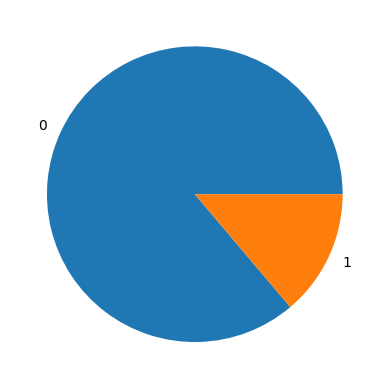

In [62]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

Involve_killing or not distribution

As we can see the number of killed persons in 1 out of 2 clusters is 0.

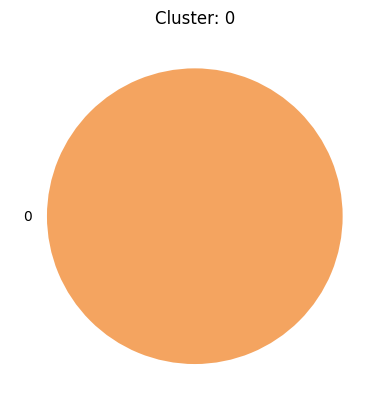

involve_killing
0    12256
Name: count, dtype: int64


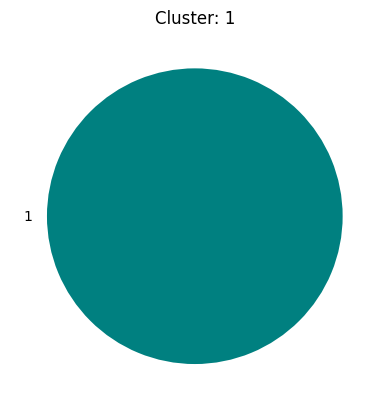

involve_killing
1    1967
Name: count, dtype: int64


In [63]:
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[dbscan.labels_ == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)

## Best clustering method
From our experiments we obtained the best performances from the DB_Scan Clustering, so we selected it as our final method by looking at the distribution of the clusters and to the distribution of incidents involving at least one death or no death in each cluster.